#  Titanic data set classification exercise 

The purpose of the exercise is to look into the Titanic dataset and determine which passenger survived the accident. The data set is gotten from the kaggle's competition website.

## imports

In [44]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [190]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve


sb.set_style('darkgrid')

## Load data set

In [46]:
filepath ='../data/titanic/'
filename = 'train.csv'
!ls {filepath}

test.csv  train.csv


In [47]:
df = pd.read_csv(f'{filepath + filename}', sep=',')
df.columns = df.columns.str.lower() # changes the column names to lower case, this doesn't improve the dataset

In [48]:
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [49]:
df.head().T

,0,1,2,3,4
passengerid,1,2,3,4,5
survived,0,1,1,1,0
pclass,3,1,3,1,3
name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
sex,male,female,female,female,male
age,22,38,26,35,35
sibsp,1,1,0,1,0
parch,0,0,0,0,0
ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
fare,7.25,71.2833,7.925,53.1,8.05


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [51]:
df.shape

(891, 12)

In [52]:
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


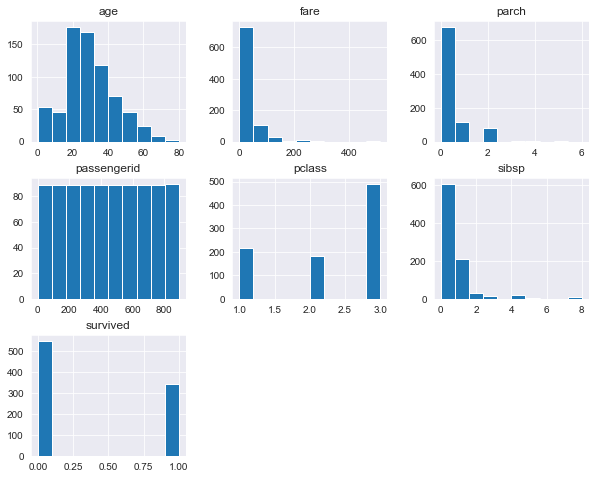

In [53]:
df.hist(figsize=(10, 8))
plt.show()

In [54]:
df.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

##  Data preprocessing

### Dataset expansion

Before dealing with missing data, let's first expand the data set. I would focus on only
- The `age` column
- The `name` column
- The `fare` column 

I am creating a new column that looks at the **age** distribution and group each individual into either **Teen**, **youth**, **Adult** or **Old**.

In [56]:
'''This function does a conditional check of the age range and returns a age category, 
if the age value is missing it returns a np.nan value'''

def age_dist(x):
    if x < 21:
        return 'young'
    elif x >=21 and x <= 40:
        return 'youth'
    elif x >=41 and x <= 60:
        return 'adult'
    elif x > 60 :
        return 'old'
    else :
        return np.nan
    
df['age_class'] = df['age'].apply(lambda x : age_dist(x))

In [58]:
df['age_class'].unique() # check if the function worked

array(['youth', nan, 'adult', 'young', 'old'], dtype=object)

Doing the same thing with the **fare** column. from the column's histogram plot three distinct classes can be seen. A new column which indicates the passengers societal class would be created using the the histogram distribution. The classes are **poor**, **middle class** and **rich**

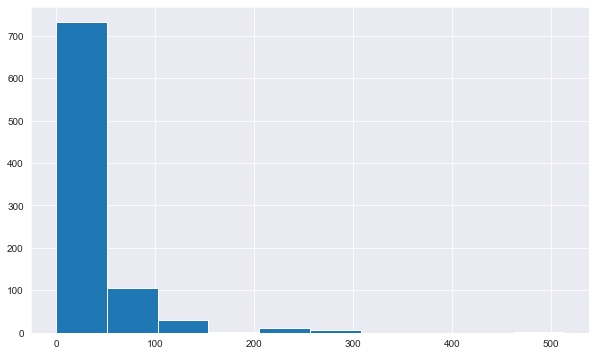

In [59]:
df.fare.hist(figsize=(10, 6))
plt.show()

In [60]:
df['social_class'] = pd.cut(df['fare'], bins=[0, 50, 100, np.inf], labels=['poor',  'middel_class', 'rich'])

In [62]:
df['social_class'].unique()

[poor, middel_class, rich, NaN]
Categories (3, object): [poor < middel_class < rich]

For the **name** column, two extra columns would be extracted from it.
<!-- - **Marital status** of the passenger -->
- Boolean column that indicates if the passenger has a **Siblin**

In [64]:
df['sib_present'] = df.sibsp.apply(lambda x : x >= 1 , True)

In [65]:
df['sib_present'].unique()

array([ True, False])

## Visualization 

Would only look at the interactions amongst the **age_class**, **social_class** , **sex** and **survived** columns.

### Age_class

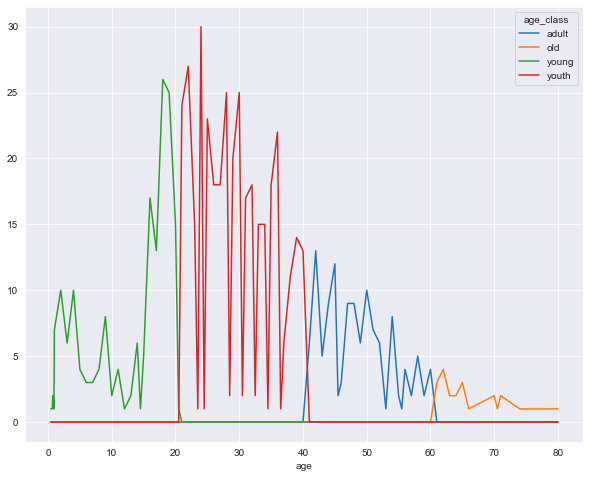

In [81]:
pd.crosstab(df['age'], df['age_class']).plot(figsize=(10, 8))
plt.show()

In [146]:
# Number of passengers that survived in each age class
pd.crosstab(df['survived'], df['age_class'])

age_class,adult,old,young,youth
survived,,,,
0,76,17,98,231
1,50,5,82,153


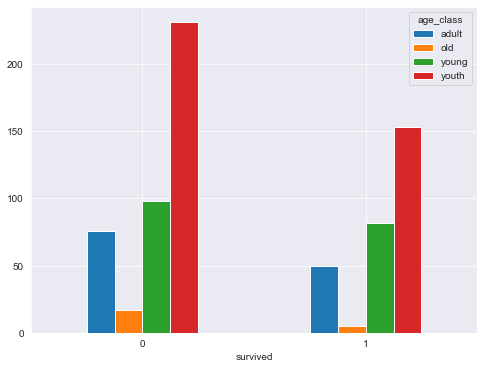

In [101]:
pd.crosstab(df['survived'], df['age_class']).plot.bar(figsize=(8, 6))
plt.xticks(rotation=0)
plt.show()

In [147]:
# Number of passengers sex in each age class
pd.crosstab(df['sex'], df['age_class'])

age_class,adult,old,young,youth
sex,,,,
female,45,3,77,136
male,81,19,103,248


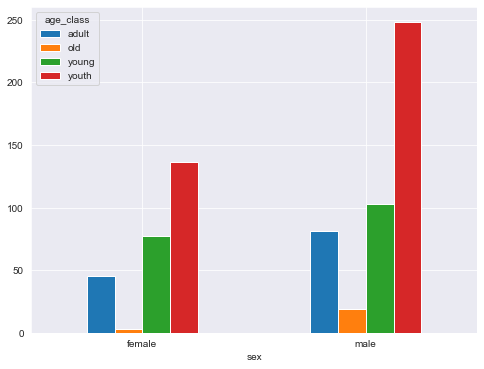

In [134]:
pd.crosstab(df['sex'], df['age_class']).plot.bar(figsize=(8, 6))
plt.xticks(rotation=0)
plt.show()

This section splits the data set into each sex and finds the survival ratio of each sex according to their age_class

In [138]:
female = df[df['sex'] == 'female']
male = df[df['sex'] == 'male']

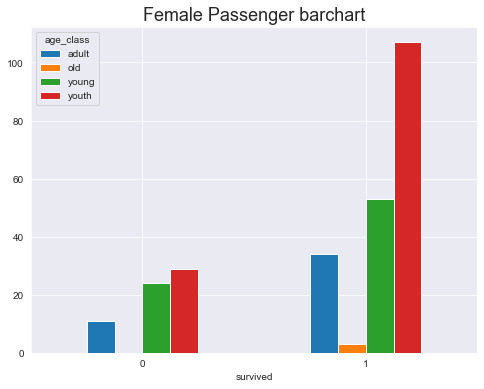

In [145]:
pd.crosstab(female['survived'], female['age_class']).plot.bar(figsize=(8, 6))
plt.title('Female Passenger barchart', fontsize=18)
plt.xticks(rotation=0)
plt.show()

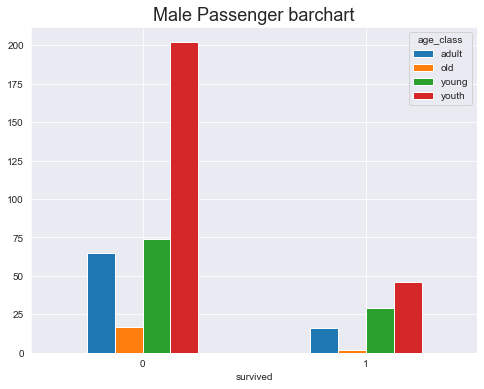

In [144]:
pd.crosstab(male['survived'], male['age_class']).plot.bar(figsize=(8, 6))
plt.title('Male Passenger barchart', fontsize=18)
plt.xticks(rotation=0)
plt.show()

### social class

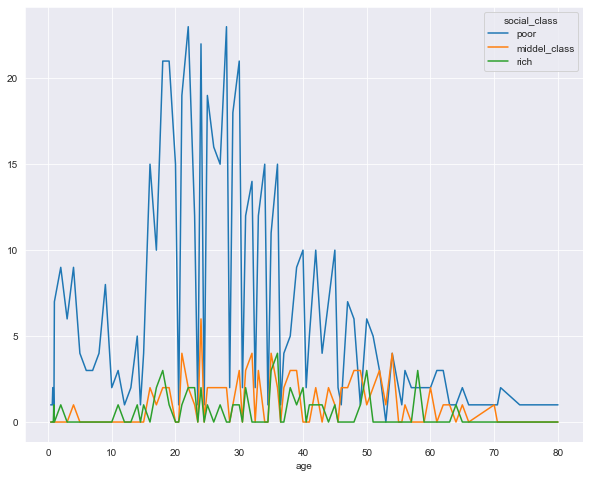

In [112]:
pd.crosstab(df['age'], df['social_class']).plot(figsize=(10, 8))
plt.show()

In [106]:
pd.crosstab(df['social_class'], df['age_class'])

age_class,adult,old,young,youth
social_class,,,,
poor,85,17,160,305
middel_class,29,4,8,49
rich,11,1,11,25


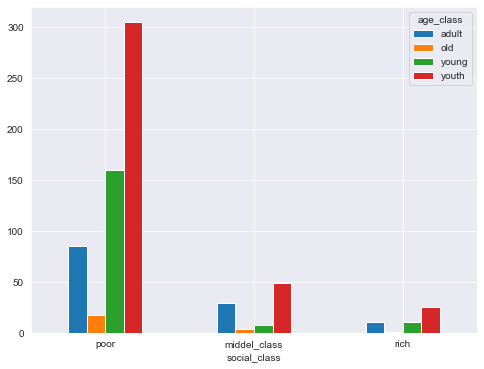

In [107]:
pd.crosstab(df['social_class'], df['age_class']).plot.bar(figsize=(8, 6))
plt.xticks(rotation=0)
plt.show()

In [108]:
pd.crosstab(df['survived'], df['social_class'])

social_class,poor,middel_class,rich
survived,,,
0,484,37,14
1,232,70,39


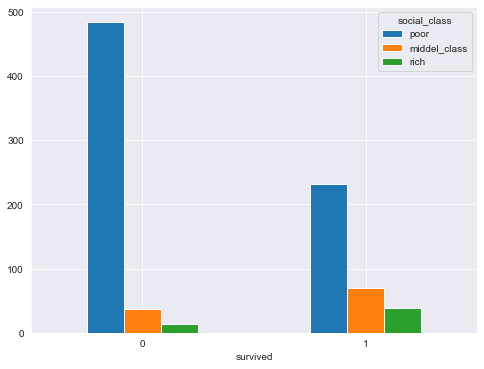

In [109]:
pd.crosstab(df['survived'], df['social_class']).plot.bar(figsize=(8, 6))
plt.xticks(rotation=0)
plt.show()